In [65]:
GPU_ID = 3
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_ID)

import numpy as np

import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile
from collections import defaultdict
from io import StringIO
from PIL import Image
import time
sys.path.append("..")  #Not sure if I need this line if I run it in the parental directory
from utils import label_map_util
import glob
import cv2
from matplotlib import pyplot as plt
from nms.py_cpu_nms import py_cpu_nms as nms

%matplotlib inline

MODELS = ['rc1', 'faster_rcnn_inception_v2_coco_2017_11_08']




NUM_CLASSES = 9
PATH_TO_LABELS = "data/AI_VMS_label_map.pbtxt"
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


#Get the session from the specified model
def load_model(model, dynamic_memory=True):


    #Dynamically allocating memory
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=dynamic_memory
    sess = tf.Session(config=config)    
    PATH_TO_CKPT = os.path.join(model , 'frozen_inference_graph.pb')
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')

    return tf.Session(graph=detection_graph, config=config)

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)





def translate_result_NMS(boxes, scores, classes, im_width, im_height, thresh, roi=(0,0,0,0), NMS_THRESH=0.7, TYPE_NUM=90):
    #Normalizing the detection result
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)    
    
    thresh_mask = scores > thresh
    
    scores = scores[thresh_mask]
    boxes = boxes[thresh_mask]
    classes = classes[thresh_mask].astype(int)
    
    outputs = []   
    
    for cls_ind in range(TYPE_NUM):
        cls_mask = (classes == cls_ind)
        if np.sum(cls_mask) <= 1:
            continue           
        filtered_boxes = boxes[cls_mask]
        filtered_scores = scores[cls_mask]
        dets = np.hstack((filtered_boxes,  filtered_scores[:, np.newaxis]))
        keep = nms(dets, NMS_THRESH)

        filtered_boxes = filtered_boxes[keep]
        filtered_scores = filtered_scores[keep]


        for i, score in enumerate(filtered_scores):      
            #Stop when score is lower than threshold since the score is sorted
            #!!!!Performance of this line can be improved!!!！


            class_name = category_index[cls_ind]['name']
            ymin, xmin, ymax, xmax = filtered_boxes[i]
            left, right, top, bottom = (xmin * im_width, xmax * im_width,\
                                      ymin * im_height, ymax * im_height)          
            #Allocating result into ouput dict
            output = {}      

            output['score'] = score
            output['class'] = class_name
            output['x'] = left + roi[0]
            output['y'] = top + roi[1]
            output['width'] = right-left
            output['height'] = bottom-top
            #Append each detection into a list
            outputs.append(output)
    return outputs


def translate_result(boxes, scores, classes, num_detections, im_width, im_height, thresh, roi=(0,0,0,0), NMS_THRESH=0.7):
    #Normalizing the detection result
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes)    
    
    thresh_mask = scores > thresh
    
    scores = scores[thresh_mask]
    boxes = boxes[thresh_mask]
    classes = classes[thresh_mask]
    
    outputs = []        
    for i, score in enumerate(scores):      
        #Stop when score is lower than threshold since the score is sorted
        #!!!!Performance of this line can be improved!!!！
       

        class_name = category_index[classes[i]]['name']
        ymin, xmin, ymax, xmax = boxes[i]
        left, right, top, bottom = (xmin * im_width, xmax * im_width,\
                                  ymin * im_height, ymax * im_height)          
        #Allocating result into ouput dict
        output = {}      

        output['score'] = score
        output['class'] = class_name
        output['x'] = left
        output['y'] = top
        output['width'] = right-left
        output['height'] = bottom-top
        #Append each detection into a list
        outputs.append(output)
    return outputs


def detect(sess, img_path, thresh=0.7, NMS_THRESH=0.7):
    #img = Image.open(img_path)
    #
    #img_np = load_image_into_numpy_array(img)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)    
    img_height, img_width, _ = img.shape
    img_np_expanded = np.expand_dims(img, axis=0)
    
    #Initalization of output and input tensors for session
    img_tensor = sess.graph.get_tensor_by_name('image_tensor:0')
    boxes = sess.graph.get_tensor_by_name('detection_boxes:0')
    scores = sess.graph.get_tensor_by_name('detection_scores:0')
    classes = sess.graph.get_tensor_by_name('detection_classes:0')
   
    
    outputs = [boxes, scores, classes]
    feed_dict = {img_tensor: img_np_expanded}
    boxes, scores, classes = sess.run(outputs,feed_dict=feed_dict) 
    print(np.max(scores))
 
    return translate_result_NMS(boxes, scores, classes, img_width,\
                            img_height,thresh, NMS_THRESH=NMS_THRESH)



def viz_detections(img_path, outputs):
    """Draw detected bounding boxes."""
    im = cv2.imread(img_path)
    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(im, aspect='equal')
    print("Total {} objects".format(len(outputs)))

    for output in outputs:
        score = output['score'] 
        class_name = output['class']
        x = output['x']
        y = output['y']
        width = output['width']
        height = output['height']   
      

        ax.add_patch(
            plt.Rectangle((x, y),
                          width,
                          height, fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(x, y - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')


    plt.axis('off')
    plt.tight_layout()
    plt.draw()

    


In [66]:
model = MODELS[0]
sess = load_model(model)
def demo(img_dir, NMS_THRESH):
   

    TEST_IMAGE_PATHS = glob.glob(img_dir)
  
    for img_path in TEST_IMAGE_PATHS:
        tic = time.time()
        result = detect(sess, img_path, NMS_THRESH=NMS_THRESH)
        outputs = result
        toc = time.time()
        for output in outputs:                     
            score = output['score'] 
            class_name = output['class']
            x = output['x']
            y = output['y']
            width = output['width']
            height = output['height']
            print("Total: {0:.2f} seconds".format(toc-tic))
        viz_detections(img_path, outputs)

3.6897585e-05
Total 0 objects
3.230484e-08
Total 0 objects


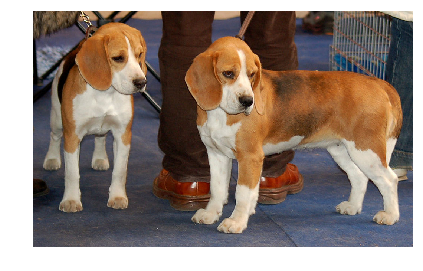

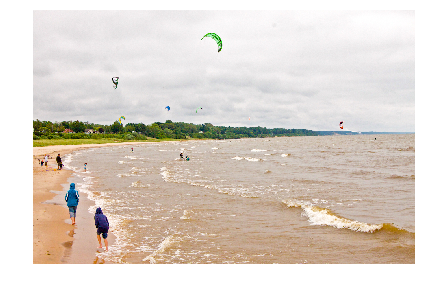

In [67]:
TEST_IMAGE_PATHS = glob.glob("test_images/*.jpg")

for img_path in TEST_IMAGE_PATHS:
    tic = time.time()
    result = detect(sess, img_path, NMS_THRESH=NMS_THRESH)
    outputs = result
    toc = time.time()
    for output in outputs:                     
        score = output['score'] 
        class_name = output['class']
        x = output['x']
        y = output['y']
        width = output['width']
        height = output['height']
        print("Total: {0:.2f} seconds".format(toc-tic))
    viz_detections(img_path, outputs)

In [62]:
outputs

[]

Total 0 objects
Total 0 objects


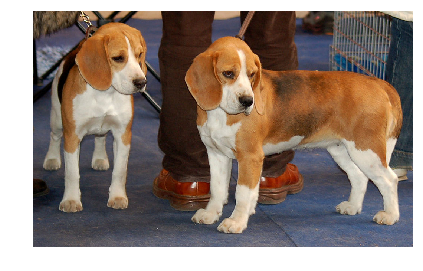

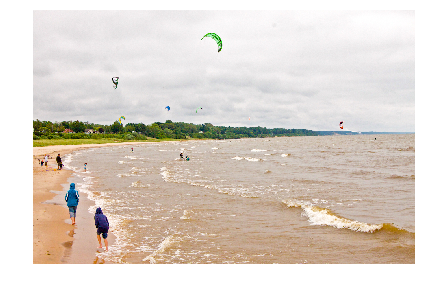

In [59]:
img_dir = "test_images/*.jpg"
NMS_THRESH = 1
demo(img_dir, NMS_THRESH)

In [53]:
outputs

[{'class': u'person',
  'height': 113.1381402015686,
  'score': 0.9778828,
  'width': 131.17408752441406,
  'x': 472.3576068878174,
  'y': 418.8618597984314},
 {'class': u'person',
  'height': 96.59533166885376,
  'score': 0.96885765,
  'width': 125.28810501098633,
  'x': 205.6455373764038,
  'y': 433.4532551765442},
 {'class': u'person',
  'height': 135.28249382972717,
  'score': 0.9643577,
  'width': 119.55151557922363,
  'x': 679.281759262085,
  'y': 396.15783047676086},
 {'class': u'person',
  'height': 176.9834065437317,
  'score': 0.95132405,
  'width': 129.10507917404175,
  'x': 2.0334720611572266,
  'y': 324.4216125011444},
 {'class': u'person',
  'height': 77.0434021949768,
  'score': 0.9393379,
  'width': 103.49404811859131,
  'x': 339.4568681716919,
  'y': 453.63433623313904},
 {'class': u'person',
  'height': 98.72086262702942,
  'score': 0.9288022,
  'width': 100.77027976512909,
  'x': 5.622640252113342,
  'y': 433.2791373729706},
 {'class': u'person',
  'height': 172.0314